In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

TypeError: ignored

In [ ]:
diabetes= pd.read_csv('diabetes.csv')

# Feature Engineering

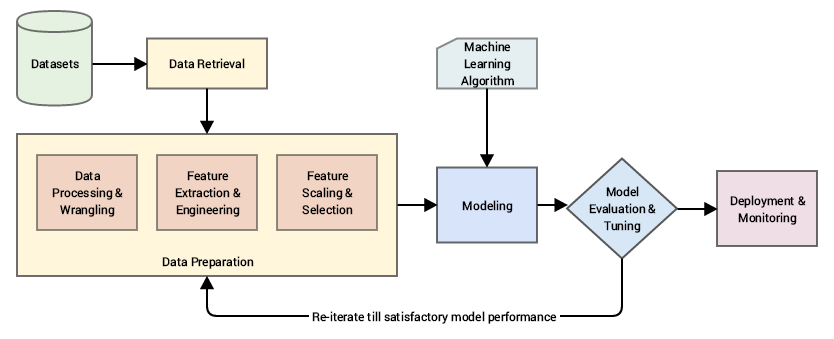

In this step, there are 4 topics to consider and handle to prepare the dataset.



1.   Outliers
2.   Missing Values
3.   Feature Extraction
4.   Encoding & Scaling

## Analyse outliers and missing values
 **Outlier:** Values that deviate considerably from the general trend in the data. Especially in linear problems, the effects of outliers are more severe. They have less impact on tree methods, but still, need to be considered.

## Method to determine outliers

The critical point is to determine the acceptable threshold value, which are up limit and low limit. After determining the threshold value, outliers are caught based on these values. Methods by which we can catch the threshold value:

* Industry knowledge
* Standard deviation approach
* Z-score approximation
* **Boxplot**(interquartile range-IQR) method (as univariate)
* **LOF Method** => Multivariate

Once we locate the outliers, they may be deleted, replaced with thresholds, etc.

In [ ]:
diabetes.describe().T

There are two points that we have to consider:
* "Insulin" has high standar deviation, the quartile values are are large, and the oulier is clear.
* "SckinThickness" quartile distribution is uneven.

In [ ]:
sns.boxplot(x=diabetes["Insulin"])

In [ ]:
sns.boxplot(x=diabetes["SkinThickness"])

The critical point in the outlier is define the threshold. We will be using IQR method.

We set up a "fence" outside of Q1 and Q3. Any values that fall outside of the fence are considered outliers.

$$IQR = Q_3-Q_1$$

* $Q_3$: 75% quantile
* $Q_1$: 25% quantile

Up limit is defined as 1.5 times bigger than $Q_3$, and the low limit is define as 1.5 times smaller value than $Q_1$.


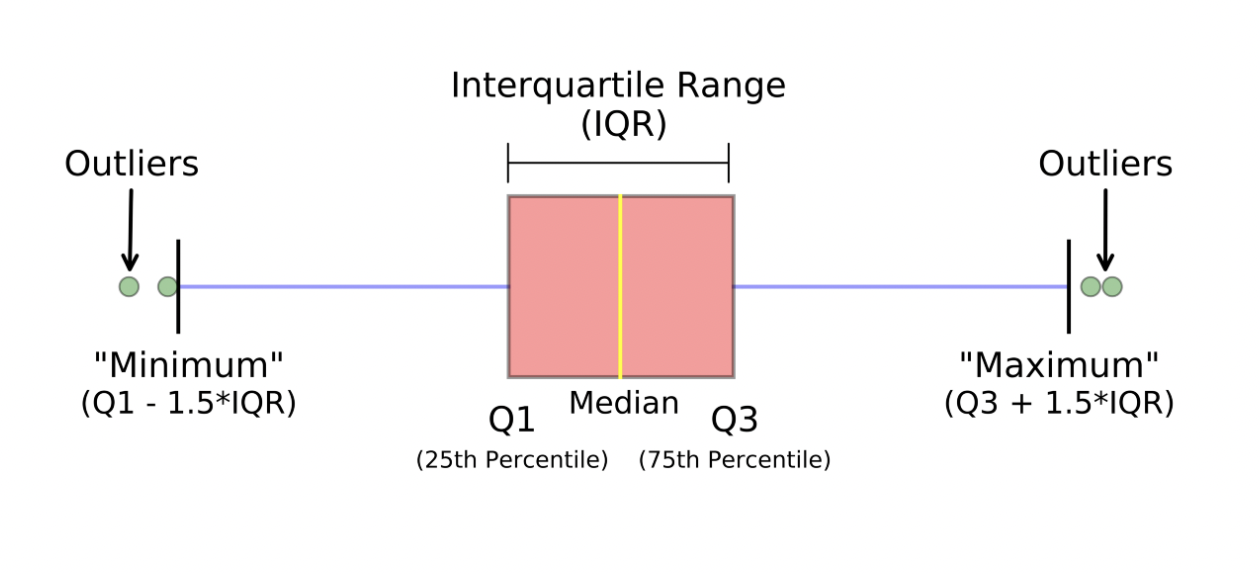

In [ ]:
diabetes.describe()['Pregnancies']['25%']

In [ ]:
def outlier_thresholds(df, col_name):
  data_qtles = df.describe()
  q1 = data_qtles[col_name]['25%']
  q3 = data_qtles[col_name]['75%']
  IQR = q3-q1
  up_limit = q3 + 1.5*IQR
  low_limit = q1 - 1.5*IQR
  return low_limit, up_limit

In [ ]:
for i in diabetes.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(diabetes,i)))

In [ ]:
low, up = outlier_thresholds(diabetes, "Pregnancies")
diabetes[((diabetes["Pregnancies"] < low) | (diabetes["Pregnancies"] > up))]


# Missing values
* Deleting
* Value Assignment Methods(average, mode, median, etc)
* Predictive Methos (ML statistical methods, etc.)

In [4]:
num_cols = len(diabetes.columns)

NameError: ignored

In [ ]:
#diabetes=pd.read_csv("diabetes (1).csv")

In [ ]:
num_cols_miss = [i for i in diabetes.columns if i != ("Pregnancies") and i != "Outcome"]
for i in num_cols_miss:
    diabetes[i] = diabetes.apply(lambda x: np.nan if x[i] == 0 else x[i], axis=1)

In [ ]:
diabetes.head()

### Analysis null values

In [ ]:
diabetes.isnull().sum()

In [ ]:
import missingno as msno

In [ ]:
# the number of non-missing data
msno.bar(diabetes)

Missing data:
* y axis: indexes
* x axis: variable
* black: non-missing index
* while: missing index(NaN)

In [ ]:
msno.matrix(diabetes)

Heatmap shows the correlation of missing values on variables.

In [ ]:
msno.heatmap(diabetes)


Notice the strong positive correlation between "SkinThickness" and "Insulin" both have many missing values

In [5]:
def missing_values_table(dataframe, na_name=False):
    # only take missing columns
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)  # number of missing value
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # ratio
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])  # make table
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
na_cols = missing_values_table(diabetes, True)

Lets create a table that relate the target variable and the missing data

In [ ]:
def missing_target(df, target, na_col):
  df_temp = df.copy()
  for col in na_cols:
    df_temp[col + '_NA_FLAG'] = np.where(df_temp[col].isnull(),1,0)
  na_flags = df_temp.loc[:, df_temp.columns.str.contains("_NA_")].columns
  print(na_flags)
  for col in na_flags:
        print(df_temp.groupby(col)[target].sum().head())

        print(pd.DataFrame({"TARGET_MEAN": df_temp.groupby(col)[target].mean(),
                            "Count": df_temp.groupby(col)[target].count()}), end="\n\n\n")

In [ ]:
missing_target(diabetes,"Outcome",na_cols)

Lets observe Glucose, there are 763 non-missing values and 5 missing values. The mean Outcome for non/missing values is 0.349 and the mean of Outcome for missing values is 0.4.


In [ ]:
corr_matrix = diabetes.corr()
corr_matrix["Outcome"].sort_values(ascending=False)

# Pre-processing (Solve Outliers and Missing Values)

## Missing Values:
* Deleting: remove rows of missing data
```
df.dropna(inplace=True)
```

* Assign Values: Fill the Nan values with mean, median or mode, even in some instances we may fill with zero.
```
 X[col_name] = X[col_name].fillna(X[col_name].median())
```

* Predective Methods: Based on ML models, or statistical methods.
Before we have to consider:
  * Transform categorical data to one hot encoder.
  * KNN is a distance - base algorithm, we need to standarize the variables.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_ml = diabetes.copy()

# standardization
scaler = MinMaxScaler()
df_ml = pd.DataFrame(scaler.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

In [ ]:
# fill Nan with KNN algorithm

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_ml = pd.DataFrame(imputer.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

 Reverse the transformed data

In [ ]:
df_ml = pd.DataFrame(scaler.inverse_transform(df_ml), columns=df_ml.columns)
df_ml.head()

In [ ]:
df_ml.describe().T

What to choose?

For this problem, since two variables have many missing values, making a prediction may not be logical for these.

We can decide what columns use the predictive method, and the remain columns use the assign method.

In [ ]:
diabetes = pd.read_csv('diabetes.csv')

In [ ]:
diabetes.head()

In [ ]:
diabetes_data = diabetes.copy(deep = True)
#Replace the zero values to Nan, it is easy to count the null values
diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
na_cols = missing_values_table(diabetes_data, na_name=True) # columns that includes missing values
n_miss = diabetes_data[na_cols].isnull().sum() # number of missing values on variables

# 100 as a threshold, it is open to comment
na_cols_ml = [i for i in n_miss.index if n_miss[i] < 100]
na_cols_med = [i for i in n_miss.index if n_miss[i] > 100]
print("Columns that will be applied ML model:", na_cols_ml)
print("Columns that will be filled with median:", na_cols_med)


In [ ]:
medians = diabetes_data.median()
medians

In [ ]:
for cols in na_cols_med:
  diabetes_data[cols] = diabetes_data[cols].fillna(medians[cols])

In [ ]:
diabetes_data.head()

In [ ]:
scaler = MinMaxScaler()
diabetes_data[na_cols_ml] = pd.DataFrame(scaler.fit_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

In [ ]:
imputer = KNNImputer(n_neighbors=5)
diabetes_data[na_cols_ml] = pd.DataFrame(imputer.fit_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

In [ ]:
diabetes_data.info()

In [ ]:
diabetes_data[na_cols_ml] = pd.DataFrame(scaler.inverse_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

In [ ]:
diabetes_data.describe().T

In [ ]:
diabetes_data.info()

# Outliers
  * Local Outlier Factor (LOF): Helps to define outliers accordingly by ordering the observations based on the density at their location. The local density of a point mean the neigborhoods around that point. If a point is significantly less dense than its neigbors, then that point is in a more sparce region, so there may be an outlier. The LOF method allows us to calculate a distance score based on neighborhoods.
  LOF computes the local density deviation of a given data point with respect to its neighbors



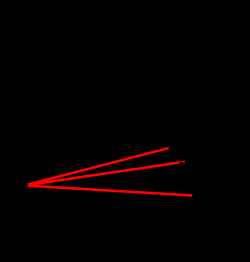

LOF methods provides a score, the closer the score to 1, the better. If the score is away from 1, the probability of the observation being outlier increases. The LOF method is also used to compute thresholds.

### Example
 We have "Age" and "Pregnancies" variables, if you observe the data separately, may not be any outlier. But analyze together and you may find strange data.



 ### IMAGINE AN EXAMPLE OF A POSSIBLE OUTLIER




In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
### Example
clf = LocalOutlierFactor(n_neighbors=20)

```negative_outlier_factor``` - The opposite LOF of the training samples. The higher, the more normal.  Inliers tend to have a LOF score close to 1, but neg_outlier_factor is close to -1

In [ ]:
clf.fit_predict(diabetes_data)  # returns LOF scores
df_scores = clf.negative_outlier_factor_ # keep scores to observe (negative)

In [ ]:
len(df_scores)

In [ ]:
print(df_scores[0:5])
print(np.sort(df_scores)[0:5])

The ```negative_outlier_factor``` method gives scores as negative. Therefore, if the scores are close to -1, the result becomes not an outlier, not being close to -1 leads to outlier. For example, scores from -1 to -10, values close to -10 tend to be more outlier.

In [ ]:
# elbow method
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')

In [ ]:
th = np.sort(df_scores)[3]

In [ ]:
diabetes_data[df_scores < th]

In [ ]:
diabetes_data.describe([0.01, 0.05, 0.25, 0.50, 0.75, 0.90, 0.99]).T

For instance, for the 13th index, while SkinThickness is close to 25% quantile, Insulin is max. On the 445th index, maybe when Glucose and BMI are close to high values, but Insuline is minimum, and this kind of combination may not be possible.


Being close(or be exactly) to max or min values are not obligatory. These are just comments without any industry knowledge, maybe these are wrong but these kinds of comments have to be done for understanding the data.


There is just 3 observation on the data set, so they can be deleted.

In [ ]:
print("Before delete outliers:", diabetes_data.shape)
print(diabetes_data[df_scores < th].index) # indexes of outliers, just for observation
diabetes_data.drop(axis=0, labels=diabetes_data[df_scores < th].index, inplace=True)
print("After delete outliers:", diabetes_data.shape)

* IQR method: we have already compute the thresholds.
We can also use quantiles as 5 and 95, because deleting or filling according to 25-75 percentile would create a serious data loss and residue.
The proportion of these depends on the problem and dataset

In [ ]:
# take the computed threshold and re-assign the outliers
def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit


In [1]:
# before reasignment
diabetes_data.describe().T

NameError: ignored

In [ ]:
num_cols

In [3]:
num_cols = []
for col in diabetes_data.columns:
  if col != 'Outcome':
    num_cols.append(col)
print(num_cols)

NameError: ignored

In [ ]:
for col in num_cols:
    replace_with_thresholds(diabetes_data, col)

In [ ]:
# after reasignment
diabetes_data.describe().T

# Feature Extraction
Once the data is prepared, we may try with new combinations of our valiables, it canbe done by mathematical operations, some times a numerical value with a categorical variable. Sometime is usefull transform the numerical data into categories or ranges

In [ ]:
diabetes_data["Pregnancies"] = diabetes_data["Pregnancies"].apply(lambda x: int(x))

Lets propose 3 categories for the number of pregnancies.
* [0,2] -> "Normal"
* [3,6]->"Above Normal"
* [6,more] -> "Extreme"

Lets propose 3 categories for age.

* [18,25]->"Young"
* [26,40] -> "Mature"
* [40,more]->"Old"

Lets propose 3 categories for levels of glucose.

* [0,69]->"Low"
* [70,100] -> "Normal"
* [101,125]->"Medium"
* [126,more]->"High"

In [ ]:
diabetes_data["NumOfPreg"] = pd.cut(diabetes_data["Pregnancies"], bins=[-1, 3, 6, diabetes_data["Pregnancies"].max()], labels=["Normal", "Above Normal","Extreme"])
diabetes_data["AgeGroup"] = pd.cut(diabetes_data["Age"], bins=[18, 25, 40, diabetes_data["Age"].max()], labels=["Young", "Mature", "Old"])
diabetes_data["GlucoseLevel"] = pd.cut(diabetes_data["Glucose"], bins=[diabetes_data["Glucose"].min(), 69,100, 125, diabetes_data["Glucose"].max()], labels=["Low", "Normal","Medium", "High"])

New numerical column

In [ ]:
diabetes_data["BMIns"] = diabetes_data["BMI"]*diabetes_data["Insulin"] # numerical
diabetes_data["BMInsGroup"] = pd.qcut(diabetes_data["BMIns"], 3, labels=["Low", "Medium", "High"]) # categorical

In [ ]:
diabetes_data.head()

In [ ]:
new_cat_columns = []
for cols in diabetes_data.columns:
  #print(diabetes_data[cols])
  if diabetes_data[cols].dtype.name =='category':
    new_cat_columns.append(cols)
print(new_cat_columns)

In [ ]:
new_num_data = []
for cols in diabetes_data.columns:
  #print(diabetes_data[cols])
  if diabetes_data[cols].dtype.name =='float64':
    new_num_data.append(cols)
print(new_num_data)

In [ ]:
df_scale = diabetes_data.copy()

#Scale Data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [ ]:
# standart scaler
ss = StandardScaler()
df_scale["Age_standard_scaler"] = ss.fit_transform(df_scale[["Age"]])
df_scale.head()

# robust scaler
rs = RobustScaler()
df_scale["Age_robuts_scaler"] = rs.fit_transform(df_scale[["Age"]])

# min-max scaler
# The range can be given with the feature_range=() argument
mms = MinMaxScaler() # default range from 0 to 1
df_scale["Age_min_max_scaler"] = mms.fit_transform(df_scale[["Age"]])

df_scale.head()

The choosen scaler must apply to all numerical data, the selection of scaler may depend of the algorithm to select or as an hyperparameter of the model design.

In [ ]:
rs = RobustScaler()
for i in new_num_data:
    diabetes_data[i] = rs.fit_transform(diabetes_data[[i]])
diabetes_data.head()

In [ ]:
diabetes_data= pd.get_dummies(diabetes_data, columns=new_cat_columns, drop_first=True)
diabetes_data.head()

# Train Model


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = diabetes_data["Outcome"]

In [ ]:
X = diabetes_data.drop(["Outcome"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_data, y, test_size=0.20, random_state=17)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)
